1. Добиться хорошего результата от модели, собранной на занятии (6 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

In [1]:
import pandas as pd
import numpy as np
from torch import nn 
from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn.functional as F

In [2]:
print(f"Поддерживается ли CUDA : {torch.cuda.is_available()}")
print(f'Количество гпу девайсов: {torch.cuda.device_count()}')
print(f"Переключение между гпу девайсами: {torch.cuda.device(0)}")
print(f"Характеристики видеокарты : {torch.cuda.get_device_properties(0)}")

Поддерживается ли CUDA : True
Количество гпу девайсов: 1
Переключение между гпу девайсами: <torch.cuda.device object at 0x7fd825467670>
Характеристики видеокарты : _CudaDeviceProperties(name='GeForce GTX 1650', major=7, minor=5, total_memory=3911MB, multi_processor_count=16)


**Загрузка и подготовка данных.**

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root='data/',  # путь, куда будут скачиваться данные(если download=true), 
                   # или где лежат данные(dowload=False)
    train=True,    # говорим что используем датасет для обучения  
    transform=transforms.ToTensor(), # преобразуем данные в формат тензоров
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = [
    'plane', 
    'car', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]

Данные разделим на 3 части: train, valid, test. 

На valid будем валидировать модель после каждой эпохи, на test протестируем модель после обучения.

Для этого разделим тестовые данные на 2 части (valid и test)

In [5]:
val_idx = list(range(5000))
test_idx = list(range(5000, 10000))

val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=True, 
    num_workers=8, 
    persistent_workers=True
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    sampler=val_sampler, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    sampler=test_sampler, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

In [6]:
len(valid_loader), len(test_loader)

(79, 79)

Размер в батчах. 

5000 / 64 = 78.125 (т.е. 79 батчей)

torch.Size([64, 3, 32, 32]) torch.Size([64])
dog


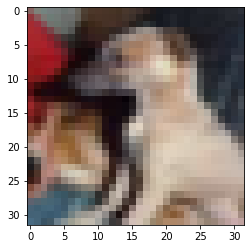

In [7]:
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)
    print(classes[labels[0]])
    plt.imshow(imgs[0].permute(1, 2, 0))
    break

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Построение и обучение модели.**

Для удобства введем несколько вспомогательных функций.

In [9]:
import time


def accuracy(preds, labels):
    return ((preds == labels).sum()/labels.shape[0]).item()


def get_predicts(model, batch):
    model.eval()
    with torch.no_grad():
        output = model(batch)
        pred = torch.max(output, 1).indices
    model.train()
    return pred


def evaluate_model(model, dataset, device, criterion):
    preds = labels = torch.tensor([]).to(device)
    loss = 0.
    model.eval()
    with torch.no_grad():
        for data, label in dataset:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss += criterion(output, label).item()
            
            pred = torch.max(output, 1).indices
            
            labels = torch.cat((labels, label))
            preds = torch.cat((preds, pred))
    model.train()
    return loss/len(dataset), accuracy(preds, labels)


def training_model(model, criterion, optimizer, train_set, valid_set, epochs, device):
    history = {
        'loss': [], 
        'metrics': [], 
        'val_loss': [], 
        'val_metrics': []
    }
    
    # Определение количества знаков для красивого вывода    
    steps = len(train_set)
    steps_n_signs = len(str(steps))
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_metric = 0.0

        model.train()
        start_time = time.time()
        
        print(f'Epoch {epoch + 1}/{epochs}', end='\n')
        
        for i, data in enumerate(train_set):
            inputs, labels = data[0].to(device), data[1].to(device)
            # подсчет метрики на трейне осуществляется по полноценному предсказанию
            # т.е. без учета dropout и пр.
            preds = get_predicts(model, inputs)
            
            # Обнуляем градиент
            optimizer.zero_grad()

            # Делаем предсказание
            outputs = model(inputs)
            # Рассчитываем лосс-функцию
            loss = criterion(outputs, labels)
            # Делаем шаг назад по лоссу
            loss.backward()
            # Делаем шаг нашего оптимайзера
            optimizer.step()
            
#             preds = torch.max(outputs, dim=1).indices

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_metric += accuracy(preds, labels)
            
            epoch_loss = running_loss / (i + 1)
            epoch_metric = running_metric / (i + 1)

            print(
                '\r' \
                f'step [{str(i + 1).zfill(steps_n_signs)}/{steps}] - ' \
                f'loss: {epoch_loss:.4f} - ' \
                f'accuracy: {epoch_metric:.4f} ', 
                end='', flush=True)
        
        duration = round(time.time() - start_time)
        
        val_loss, val_metric = evaluate_model(model, valid_set, device, criterion)
        
        history['loss'].append(epoch_loss)
        history['metrics'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metrics'].append(val_metric)
        
        print(
            f'- val_loss: {val_loss:.4f} ' \
            f'- val_accuracy: {val_metric:.4f} ' \
            f'- {duration}s ({round((duration/steps) * 1000)}ms/step)', 
            end='\n')

    print('Training is finished!')
    
    return history

In [10]:
# в словаре будем хранить обученые модели для финального предсказания на тесте
models = {}

Для начала возьмем модель, представленную на уроке.

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=5
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5
        )
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        self.fc1 = nn.Linear(
            in_features=16 * 5 * 5,
            out_features=120
        )
        
        self.fc2 = nn.Linear(
            in_features=120,
            out_features=84
        )
        
        self.fc3 = nn.Linear(
            in_features=84,
            out_features=10
        )

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
%%time
train_loss, train_acc = evaluate_model(net, train_loader, device, criterion)
valid_loss, valid_acc = evaluate_model(net, valid_loader, device, criterion)

history = training_model(net, criterion, optimizer, train_loader, valid_loader, epochs=50, device=device)

history['loss'] = [train_loss] + history['loss']
history['metrics'] = [train_acc] + history['metrics']

history['val_loss'] = [valid_loss] + history['val_loss']
history['val_metrics'] = [valid_acc] + history['val_metrics']

models['from_lesson'] = net

Epoch 1/50
step [782/782] - loss: 2.3031 - accuracy: 0.1076 - val_loss: 2.3023 - val_accuracy: 0.1106 - 6s (8ms/step)
Epoch 2/50
step [782/782] - loss: 2.3009 - accuracy: 0.1151 - val_loss: 2.2986 - val_accuracy: 0.0996 - 6s (8ms/step)
Epoch 3/50
step [782/782] - loss: 2.2869 - accuracy: 0.1082 - val_loss: 2.2567 - val_accuracy: 0.1268 - 6s (8ms/step)
Epoch 4/50
step [782/782] - loss: 2.1111 - accuracy: 0.2157 - val_loss: 2.0009 - val_accuracy: 0.2550 - 6s (8ms/step)
Epoch 5/50
step [782/782] - loss: 1.9691 - accuracy: 0.2772 - val_loss: 1.9174 - val_accuracy: 0.3098 - 6s (8ms/step)
Epoch 6/50
step [782/782] - loss: 1.8629 - accuracy: 0.3207 - val_loss: 1.8000 - val_accuracy: 0.3484 - 6s (8ms/step)
Epoch 7/50
step [782/782] - loss: 1.7027 - accuracy: 0.3818 - val_loss: 1.6125 - val_accuracy: 0.4188 - 6s (8ms/step)
Epoch 8/50
step [782/782] - loss: 1.5957 - accuracy: 0.4225 - val_loss: 1.5344 - val_accuracy: 0.4448 - 6s (8ms/step)
Epoch 9/50
step [782/782] - loss: 1.5280 - accuracy: 0.4

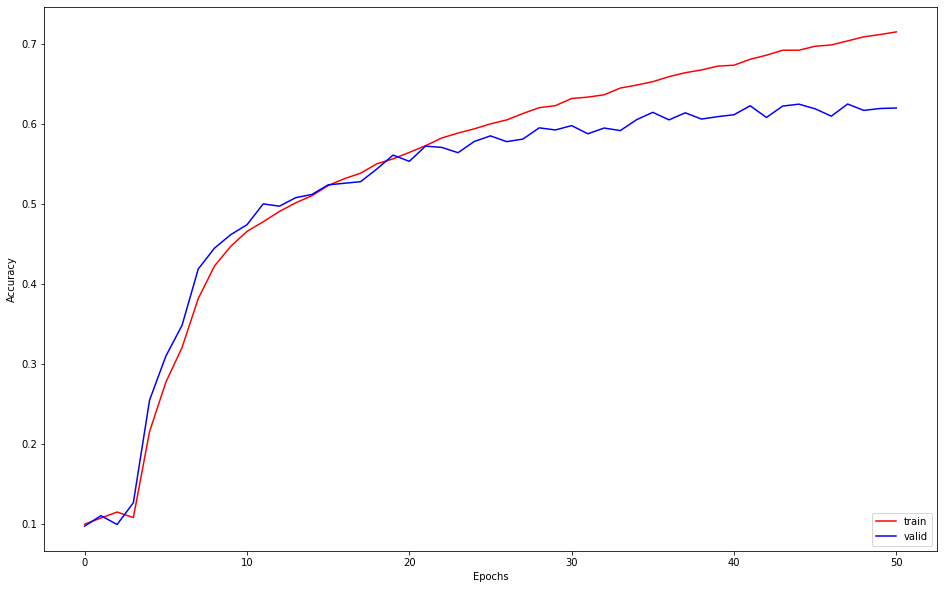

In [15]:
plt.figure(figsize=(16, 10))
plt.plot(range(51), history['metrics'], label='train', c='r')
plt.plot(range(51), history['val_metrics'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

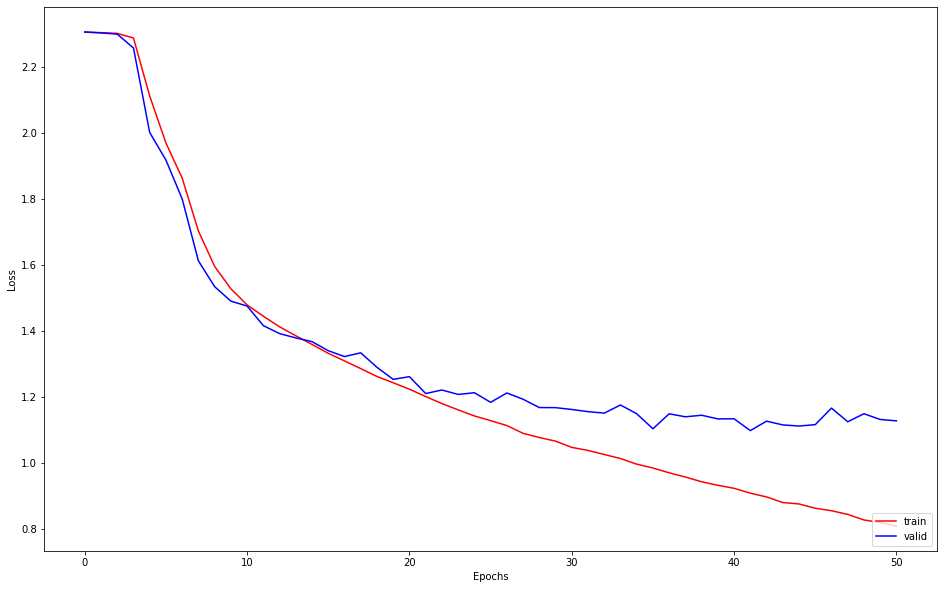

In [16]:
plt.figure(figsize=(16, 10))
plt.plot(range(51), history['loss'], label='train', c='r')
plt.plot(range(51), history['val_loss'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

Результаты оставляют желать лучшего.

Попробуем улучшить модель. 

Прежде всего можно заменить каждый сверточный слой с ядром свертки (5, 5) на сверточный блок из двух слоев с ядром (3, 3) - уменьшим количество обучаемых параметров.

Блок будет содержать:
* 2 слоя свертки с ядром (3, 3), первый слой с padding;
* MaxPooling ядро 2, шаг 2;
* Dropout (0.25)

Реализуем блок как класс - для более удобного построения модели. 

In [17]:
class BaseUnit(nn.Module):
    '''
    Базовый блок. Другие блоки будем наследовать от него.
    
    Для воспроизводимости добавлена возможность фиксации генератора псевдослучайных чисел
    '''
    def __init__(self, random_state=None):
        super().__init__()
        
        if random_state:
            torch.manual_seed(random_state)
            torch.cuda.manual_seed(random_state)
            
        torch.backends.cudnn.benchmark = (random_state == None)
        torch.backends.cudnn.deterministic = (random_state != None)

In [18]:
class ConvUnit(BaseUnit):
    '''
    Сверточный блок.
    '''
    
    def __init__(self, in_channels, out_channels, random_state=None):
        super().__init__(random_state=random_state)
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=3
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3
        )
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        self.dropout = nn.Dropout(
            p=0.25
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool(x)
        
        x = self.dropout(x)
        
        return x

Также введем полносвязный блок FCUnit.

Блок будет содержать:

* Полносвязный слой;
* Dropout.

In [19]:
class FCUnit(BaseUnit):
    '''
    Полносвязный блок.
    '''
    
    def __init__(self, in_features, out_features, dropout=0, random_state=None):
        super().__init__(random_state=random_state)

        self.fc = nn.Linear(
            in_features=in_features,
            out_features=out_features
        )
        
        self.dropout = nn.Dropout(
            p=dropout
        )

        
    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        
        return x

Сеть примет следующий вид:

* 3 блока свертки, с увеличением количества параметров (32, 64, 128);
* AvgPool для уменьшения количества параметров;
* 1 полносвязный блок 512 параметров, Dropout=0.5;
* Выходной слой с 10 выходами.

In [20]:
class Net(BaseUnit):
    
    def __init__(self, n_classes, random_state=None):
        super().__init__(random_state=random_state)
        
        # (3, 32, 32) -> (32, 15, 15)
        self.conv1 = ConvUnit(
            in_channels=3,
            out_channels=32, 
            random_state=random_state
        )
        
        # (32, 15, 15) -> (64, 6, 6)
        self.conv2 = ConvUnit(
            in_channels=32,
            out_channels=64, 
            random_state=random_state
        )
        
        # (64, 6, 6) -> (128, 2, 2)
        self.conv3 = ConvUnit(
            in_channels=64,
            out_channels=128, 
            random_state=random_state
        )
        
        # (128, 2, 2) -> (128, 1, 1)
        self.pool = nn.AvgPool2d(
            kernel_size=(2, 2)
        )
        
        self.fc1 = FCUnit(
            in_features=128, 
            out_features=512, 
            dropout=0.5, 
            random_state=random_state
        )
        
        # otput layer
        self.fc2 = nn.Linear(
            in_features=512,
            out_features=n_classes
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.pool(x)
        
        x = x.reshape(-1, 128)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [21]:
seed = 42

model1 = Net(n_classes=10, random_state=seed).to(device)

# в качестве оптимизатора будем использовать Adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())

In [22]:
model1

Net(
  (conv1): ConvUnit(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (conv2): ConvUnit(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (conv3): ConvUnit(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (fc1): FCUnit(
    (fc): 

In [23]:
# для воспроизводимости отключим перемешивание
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    sampler=val_sampler, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    sampler=test_sampler, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

In [24]:
%%time
train_loss, train_acc = evaluate_model(model1, train_loader, device, criterion)
valid_loss, valid_acc = evaluate_model(model1, valid_loader, device, criterion)

model1_hist = training_model(model1, criterion, optimizer, train_loader, valid_loader, epochs=50, device=device)

model1_hist['loss'] = [train_loss] + model1_hist['loss']
model1_hist['metrics'] = [train_acc] + model1_hist['metrics']

model1_hist['val_loss'] = [valid_loss] + model1_hist['val_loss']
model1_hist['val_metrics'] = [valid_acc] + model1_hist['val_metrics']

# зададим модель как baseline
models['baseline'] = model1

Epoch 1/50
step [782/782] - loss: 1.8500 - accuracy: 0.2989 - val_loss: 1.4964 - val_accuracy: 0.4292 - 12s (15ms/step)
Epoch 2/50
step [782/782] - loss: 1.4385 - accuracy: 0.4862 - val_loss: 1.2599 - val_accuracy: 0.5450 - 12s (15ms/step)
Epoch 3/50
step [782/782] - loss: 1.2449 - accuracy: 0.5744 - val_loss: 1.1094 - val_accuracy: 0.6094 - 12s (15ms/step)
Epoch 4/50
step [782/782] - loss: 1.1260 - accuracy: 0.6285 - val_loss: 1.0387 - val_accuracy: 0.6372 - 12s (15ms/step)
Epoch 5/50
step [782/782] - loss: 1.0325 - accuracy: 0.6694 - val_loss: 0.9402 - val_accuracy: 0.6732 - 13s (17ms/step)
Epoch 6/50
step [782/782] - loss: 0.9626 - accuracy: 0.6978 - val_loss: 0.8836 - val_accuracy: 0.6948 - 13s (17ms/step)
Epoch 7/50
step [782/782] - loss: 0.8997 - accuracy: 0.7214 - val_loss: 0.8303 - val_accuracy: 0.7144 - 13s (17ms/step)
Epoch 8/50
step [782/782] - loss: 0.8561 - accuracy: 0.7402 - val_loss: 0.8293 - val_accuracy: 0.7176 - 13s (17ms/step)
Epoch 9/50
step [782/782] - loss: 0.8143

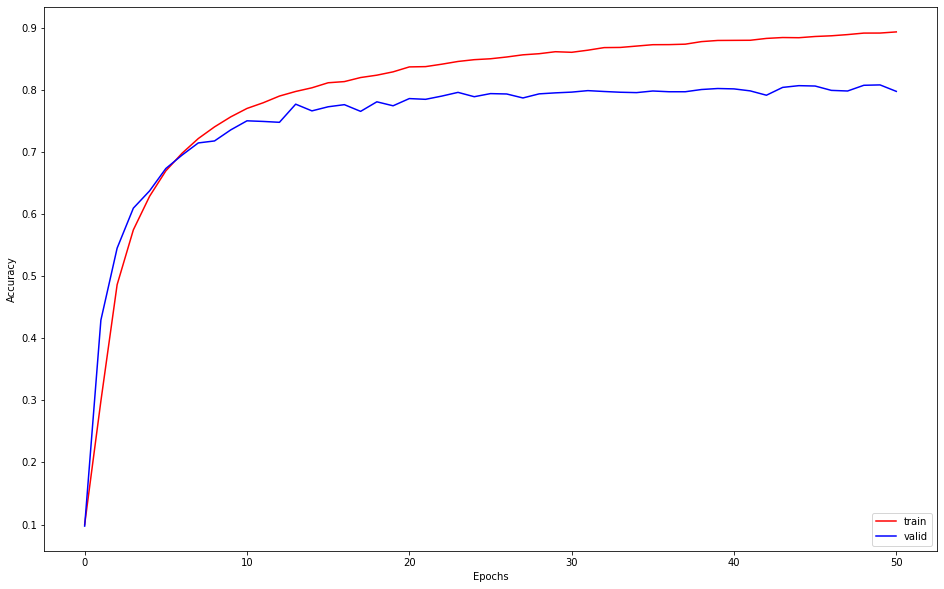

In [25]:
plt.figure(figsize=(16, 10))
plt.plot(range(51), model1_hist['metrics'], label='train', c='r')
plt.plot(range(51), model1_hist['val_metrics'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

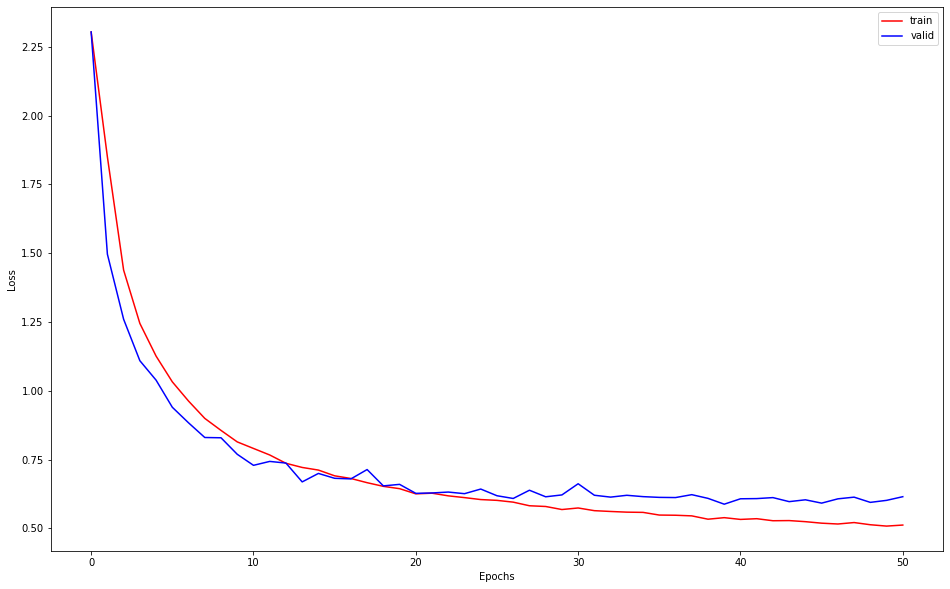

In [26]:
plt.figure(figsize=(16, 10))
plt.plot(range(51), model1_hist['loss'], label='train', c='r')
plt.plot(range(51), model1_hist['val_loss'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

**Удалось значительно улучшить результат. Попробуем ускорить/улучшить сходимость.**

Эмпирически удалось выяснить, что сочетание BatchNormalization + Dropout в конце блока свертки позволяет улучшить сходимость сети. 

В подтверждение этому наблюдению нашел работу, в которой авторы доказывают математически, что сочетание BatchNormalization + Dropout позволяет уменьшить взаимную информацию и снизить коэффициент корреляции между парами нейронов. Таким образом может быть достигнута более высокая скорость сходимости.

Ссылка на работу: https://arxiv.org/pdf/1905.05928.pdf

Введем новый блок ICUnit.

Будет в себе содержать:

* BatchNormalization
* Dropout

Блок заменит собой dropout слой в конце каждого сверточного блока.

Сверточный блок примет вид:

1. Сверточный слой, ядро 3x3, шаг 1x1, padding;
2. ReLU;
3. Сверточный слой, ядро 3x3, шаг 1x1;
4. ReLU;
5. MaxPooling, ядро 2x2, шаг 2x2;
6. IC блок (BatchNormalization + Dropout(p=0.25)).

В остальном такая же модель, с тем же числом параметров.

In [27]:
class ICUnit(BaseUnit):
    
    def __init__(self, inputs, p):
        super().__init__()
        
        self.batchnorm = nn.BatchNorm2d(inputs)
        self.dropout = nn.Dropout(p)
        
        
    def forward(self, x):
        
        x = self.batchnorm(x)
        x = self.dropout(x)

        return x

In [28]:
class ConvUnit(BaseUnit):
    
    def __init__(self, in_channels, out_channels, random_state=None):
        super().__init__(random_state=random_state)

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=3
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3
        )
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        self.IC = ICUnit(
            inputs=out_channels, 
            p=0.25
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool(x)
        
        x = self.IC(x)
        
        return x

In [30]:
class FCUnit(BaseUnit):
    
    def __init__(self, in_features, out_features, dropout=0, random_state=None):
        super().__init__(random_state=random_state)

        self.fc = nn.Linear(
            in_features=in_features,
            out_features=out_features
        )
        
        self.dropout = nn.Dropout(
            p=dropout
        )

        
    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        
        return x

In [31]:
class Net(BaseUnit):
    
    def __init__(self, n_classes, random_state=None):
        super().__init__(random_state=random_state)

        # (3, 32, 32) -> (32, 15, 15)
        self.conv1 = ConvUnit(
            in_channels=3, 
            out_channels=32, 
            random_state=random_state
        )
        
        # (32, 15, 15) -> (64, 6, 6)
        self.conv2 = ConvUnit(
            in_channels=32,
            out_channels=64, 
            random_state=random_state
        )
        
        # (64, 6, 6) -> (128, 2, 2)
        self.conv3 = ConvUnit(
            in_channels=64,
            out_channels=128, 
            random_state=random_state
        )
        
        # (128, 2, 2) -> (128, 1, 1)
        self.pool = nn.AvgPool2d((2, 2))
        
        self.fc1 = FCUnit(
            in_features=128, 
            out_features=512, 
            dropout=0.5, 
            random_state=random_state
        )
        
        self.fc2 = nn.Linear(
            in_features=512,
            out_features=n_classes
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.pool(x)
        
        x = x.reshape(-1, 128)
        x = self.fc1(x)
        x = self.fc2(x)
    
        return x

In [32]:
seed = 42

model2 = Net(10, random_state=seed).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters())

In [33]:
model2

Net(
  (conv1): ConvUnit(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (IC): ICUnit(
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.25, inplace=False)
    )
  )
  (conv2): ConvUnit(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (IC): ICUnit(
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.25, inplace=False)
    )
  )
  (conv3): ConvUnit(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3,

In [35]:
%%time
train_loss, train_acc = evaluate_model(model2, train_loader, device, criterion)
valid_loss, valid_acc = evaluate_model(model2, valid_loader, device, criterion)

model2_hist = training_model(model2, criterion, optimizer, train_loader, valid_loader, epochs=50, device=device)


model2_hist['loss'] = [train_loss] + model2_hist['loss']
model2_hist['metrics'] = [train_acc] + model2_hist['metrics']

model2_hist['val_loss'] = [valid_loss] + model2_hist['val_loss']
model2_hist['val_metrics'] = [valid_acc] + model2_hist['val_metrics']

models['IC'] = model2

Epoch 1/50
step [782/782] - loss: 1.3399 - accuracy: 0.4763 - val_loss: 0.9654 - val_accuracy: 0.6578 - 14s (18ms/step)
Epoch 2/50
step [782/782] - loss: 0.9416 - accuracy: 0.6772 - val_loss: 0.8301 - val_accuracy: 0.7090 - 14s (18ms/step)
Epoch 3/50
step [782/782] - loss: 0.8001 - accuracy: 0.7391 - val_loss: 0.6811 - val_accuracy: 0.7648 - 14s (18ms/step)
Epoch 4/50
step [782/782] - loss: 0.7193 - accuracy: 0.7734 - val_loss: 0.6554 - val_accuracy: 0.7710 - 14s (18ms/step)
Epoch 5/50
step [782/782] - loss: 0.6590 - accuracy: 0.8015 - val_loss: 0.6687 - val_accuracy: 0.7742 - 14s (18ms/step)
Epoch 6/50
step [782/782] - loss: 0.6086 - accuracy: 0.8166 - val_loss: 0.6033 - val_accuracy: 0.7946 - 14s (18ms/step)
Epoch 7/50
step [782/782] - loss: 0.5831 - accuracy: 0.8290 - val_loss: 0.5876 - val_accuracy: 0.8018 - 14s (18ms/step)
Epoch 8/50
step [782/782] - loss: 0.5420 - accuracy: 0.8497 - val_loss: 0.5637 - val_accuracy: 0.8124 - 14s (18ms/step)
Epoch 9/50
step [782/782] - loss: 0.5182

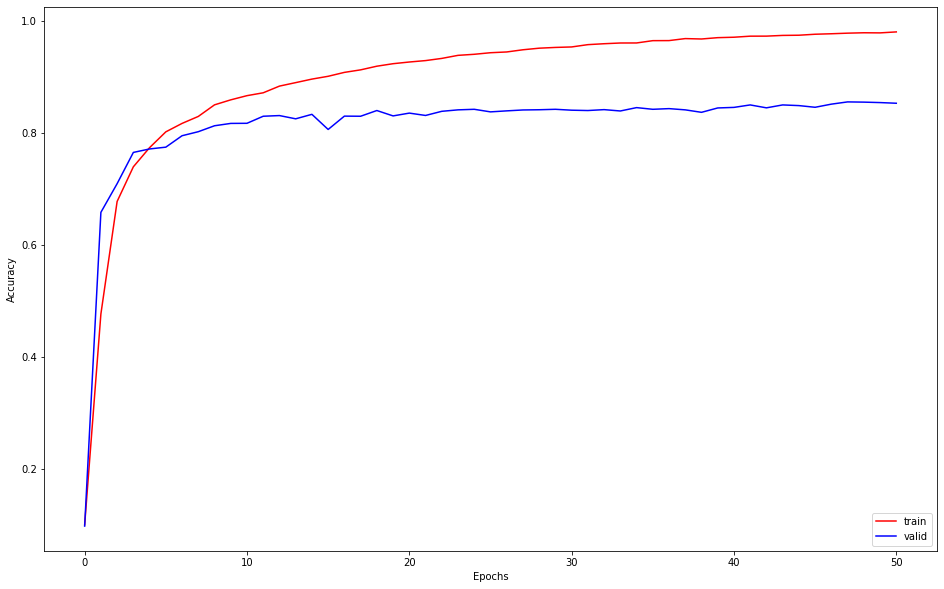

In [36]:
plt.figure(figsize=(16, 10))
plt.plot(range(51), model2_hist['metrics'], label='train', c='r')
plt.plot(range(51), model2_hist['val_metrics'], label='valid', c='b')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

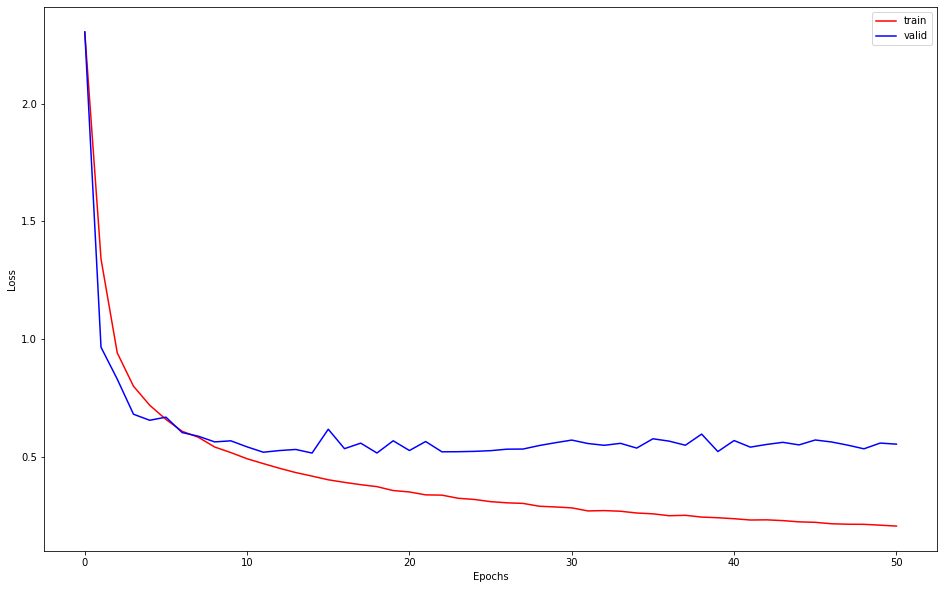

In [37]:
plt.figure(figsize=(16, 10))
plt.plot(range(51), model2_hist['loss'], label='train', c='r')
plt.plot(range(51), model2_hist['val_loss'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Значительно улучшилась сходимость, удалось увеличить скорость обучения. Но есть проблема с переобучением. Для ее решения будем использовать аугментацию обучающих данных (будем осуществлять случайные преобразования изображений).

In [38]:
random_transform = transforms.RandomApply(
                        torch.nn.ModuleList([
                            transforms.ColorJitter(
                                                contrast=(0.5, 1.5), 
                                                saturation=(0., 5.), 
                            ), 
                            transforms.RandomAffine(
                                                degrees=(-10, 10), 
                                                translate=(0.05, 0.1), 
                                                scale=(0.9, 1.1), 
                                                shear=(-5, 5), 
                            ), 
                            transforms.RandomResizedCrop(
                                                size=32, 
                                                scale=(0.9, 1.1), 
                            )
                        ]), p=0.9)


to_tensor = transforms.ToTensor()

def transform_img(img):
    img = to_tensor(img)
    return random_transform(img)

In [39]:
train_dataset = torchvision.datasets.CIFAR10(
    root='data/', 
    train=True,    
    transform=transform_img, 
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
val_idx = list(range(5000))
test_idx = list(range(5000, 10000))

val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=True, 
    num_workers=8, 
    persistent_workers=True
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    sampler=val_sampler, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    sampler=test_sampler, 
    shuffle=False, 
    num_workers=8, 
    persistent_workers=True
)

torch.Size([64, 3, 32, 32]) torch.Size([64])
deer


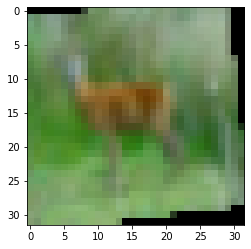

torch.Size([64, 3, 32, 32]) torch.Size([64])
truck


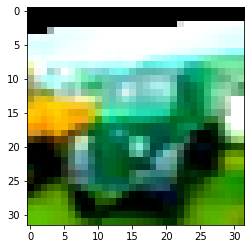

torch.Size([64, 3, 32, 32]) torch.Size([64])
ship


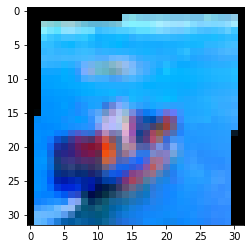

In [41]:
i = 0

for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)
    print(classes[labels[0]])
    plt.imshow(imgs[0].permute(1, 2, 0))
    plt.show()
    i += 1
    if i == 3:
        break

In [42]:
model3 = Net(10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters())

In [43]:
model3

Net(
  (conv1): ConvUnit(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (IC): ICUnit(
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.25, inplace=False)
    )
  )
  (conv2): ConvUnit(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (IC): ICUnit(
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.25, inplace=False)
    )
  )
  (conv3): ConvUnit(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3,

При помощи преобразований нам удалось расширить датасет. Соответственно потребуется больше итераций для сходимости. Увеличим количество эпох до 100.

In [44]:
%%time
train_loss, train_acc = evaluate_model(model3, train_loader, device, criterion)
valid_loss, valid_acc = evaluate_model(model3, valid_loader, device, criterion)

model3_hist = training_model(model3, criterion, optimizer, train_loader, valid_loader, epochs=100, device=device)


model3_hist['loss'] = [train_loss] + model3_hist['loss']
model3_hist['metrics'] = [train_acc] + model3_hist['metrics']

model3_hist['val_loss'] = [valid_loss] + model3_hist['val_loss']
model3_hist['val_metrics'] = [valid_acc] + model3_hist['val_metrics']

models['IC (augmented data)'] = model3

Epoch 1/100
step [782/782] - loss: 1.6558 - accuracy: 0.3815 - val_loss: 1.2317 - val_accuracy: 0.5546 - 15s (19ms/step)
Epoch 2/100
step [782/782] - loss: 1.2967 - accuracy: 0.5544 - val_loss: 0.9817 - val_accuracy: 0.6508 - 15s (19ms/step)
Epoch 3/100
step [782/782] - loss: 1.1385 - accuracy: 0.6239 - val_loss: 0.8770 - val_accuracy: 0.6910 - 15s (19ms/step)
Epoch 4/100
step [782/782] - loss: 1.0373 - accuracy: 0.6667 - val_loss: 0.7816 - val_accuracy: 0.7232 - 15s (19ms/step)
Epoch 5/100
step [782/782] - loss: 0.9710 - accuracy: 0.6987 - val_loss: 0.7941 - val_accuracy: 0.7268 - 15s (19ms/step)
Epoch 6/100
step [782/782] - loss: 0.9289 - accuracy: 0.7140 - val_loss: 0.7175 - val_accuracy: 0.7544 - 15s (19ms/step)
Epoch 7/100
step [782/782] - loss: 0.8902 - accuracy: 0.7297 - val_loss: 0.6820 - val_accuracy: 0.7658 - 15s (19ms/step)
Epoch 8/100
step [782/782] - loss: 0.8595 - accuracy: 0.7427 - val_loss: 0.6970 - val_accuracy: 0.7656 - 15s (19ms/step)
Epoch 9/100
step [782/782] - los

step [782/782] - loss: 0.5010 - accuracy: 0.8790 - val_loss: 0.4643 - val_accuracy: 0.8510 - 15s (19ms/step)
Epoch 69/100
step [782/782] - loss: 0.5030 - accuracy: 0.8801 - val_loss: 0.4393 - val_accuracy: 0.8532 - 15s (19ms/step)
Epoch 70/100
step [782/782] - loss: 0.5010 - accuracy: 0.8827 - val_loss: 0.4189 - val_accuracy: 0.8566 - 16s (20ms/step)
Epoch 71/100
step [782/782] - loss: 0.4979 - accuracy: 0.8819 - val_loss: 0.4223 - val_accuracy: 0.8576 - 16s (20ms/step)
Epoch 72/100
step [782/782] - loss: 0.4889 - accuracy: 0.8830 - val_loss: 0.4334 - val_accuracy: 0.8598 - 15s (19ms/step)
Epoch 73/100
step [782/782] - loss: 0.4994 - accuracy: 0.8826 - val_loss: 0.4217 - val_accuracy: 0.8596 - 16s (20ms/step)
Epoch 74/100
step [782/782] - loss: 0.4934 - accuracy: 0.8842 - val_loss: 0.4203 - val_accuracy: 0.8630 - 15s (19ms/step)
Epoch 75/100
step [782/782] - loss: 0.4923 - accuracy: 0.8838 - val_loss: 0.4298 - val_accuracy: 0.8588 - 15s (19ms/step)
Epoch 76/100
step [782/782] - loss: 0

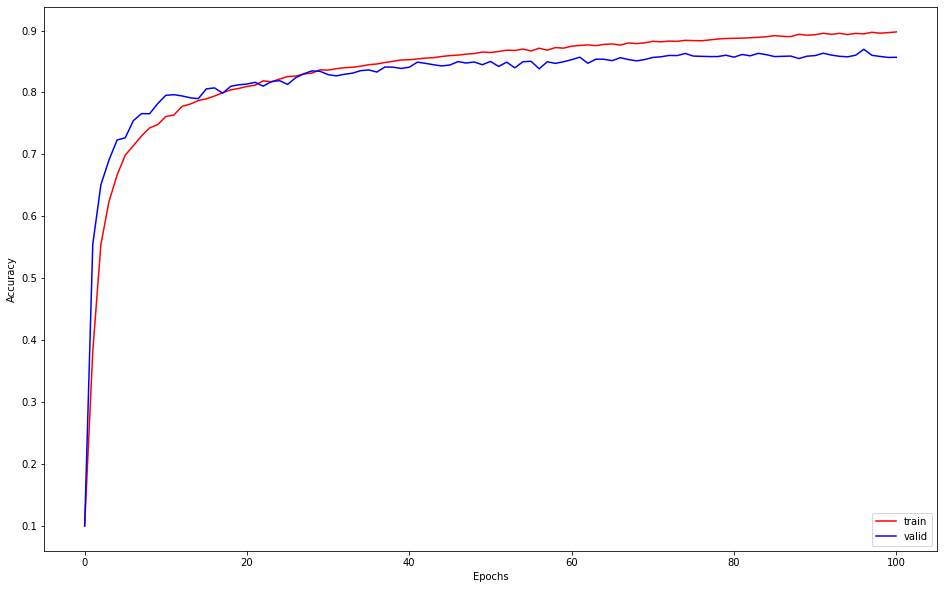

In [45]:
plt.figure(figsize=(16, 10))
plt.plot(range(101), model3_hist['metrics'], label='train', c='r')
plt.plot(range(101), model3_hist['val_metrics'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

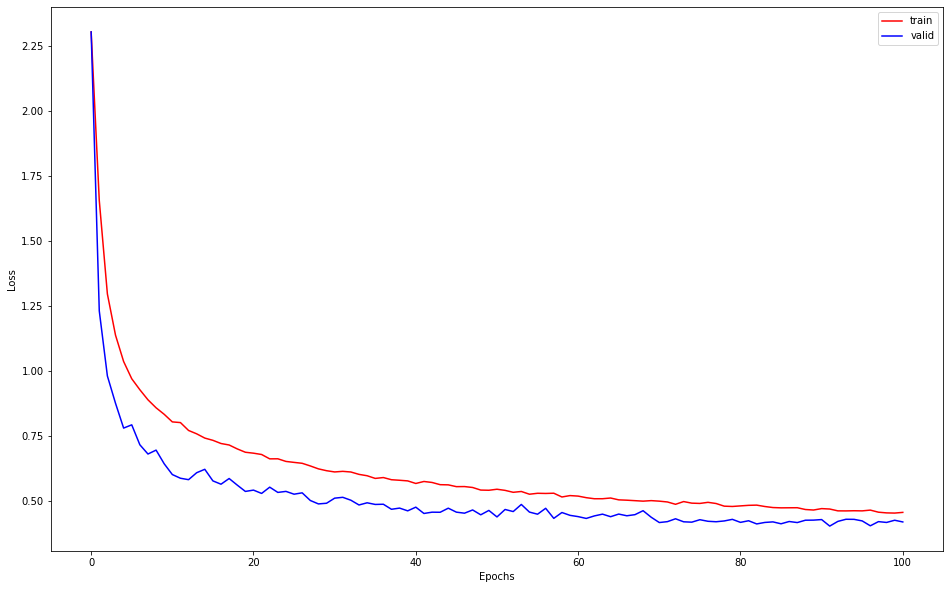

In [46]:
plt.figure(figsize=(16, 10))
plt.plot(range(101), model3_hist['loss'], label='train', c='r')
plt.plot(range(101), model3_hist['val_loss'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Для ускорения сходимости сделаем следующие изменения:

Сверточный блок
* Добавим BatchNormalization после первой свертки (без аугментации данное действие сразу приводит к переобучению);
* Уменьшим Dropout до 0.2.

In [47]:
class ConvUnit(BaseUnit):
    
    def __init__(self, in_channels, out_channels, random_state=None):
        super().__init__(random_state=random_state)

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=3
        )
        
        self.batchnorm = nn.BatchNorm2d(
            num_features=out_channels
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3
        )
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        self.IC = ICUnit(
            inputs=out_channels, 
            p=0.2
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.batchnorm(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool(x)
        
        x = self.IC(x)
        
        return x

In [48]:
class FCUnit(BaseUnit):
    
    def __init__(self, in_features, out_features, dropout=0, random_state=None):
        super().__init__(random_state=random_state)

        self.fc = nn.Linear(
            in_features=in_features,
            out_features=out_features
        )
        
        self.dropout = nn.Dropout(
            p=dropout
        )

        
    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        
        return x

In [49]:
class Net(BaseUnit):
    
    def __init__(self, n_classes, random_state=None):
        super().__init__(random_state=random_state)

        # (3, 32, 32) -> (32, 15, 15)
        self.conv1 = ConvUnit(
            in_channels=3, 
            out_channels=32, 
            random_state=random_state
        )
        
        # (32, 15, 15) -> (64, 6, 6)
        self.conv2 = ConvUnit(
            in_channels=32,
            out_channels=64, 
            random_state=random_state
        )
        
        # (64, 6, 6) -> (128, 2, 2)
        self.conv3 = ConvUnit(
            in_channels=64,
            out_channels=128, 
            random_state=random_state
        )
        
        # (128, 2, 2) -> (128, 1, 1)
        self.pool = nn.AvgPool2d(
            kernel_size=(2, 2)
        )
        
        self.fc1 = FCUnit(
            in_features=128, 
            out_features=512, 
            dropout=0.5, 
            random_state=random_state
        )
        
        self.fc2 = nn.Linear(
            in_features=512,
            out_features=n_classes
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.pool(x)
        
        x = x.reshape(-1, 128)
        x = self.fc1(x)
        x = self.fc2(x)
    
        return x

In [51]:
model4 = Net(10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters())

In [52]:
%%time
train_loss, train_acc = evaluate_model(model4, train_loader, device, criterion)
valid_loss, valid_acc = evaluate_model(model4, valid_loader, device, criterion)

model4_hist = training_model(model4, criterion, optimizer, train_loader, valid_loader, epochs=100, device=device)


model4_hist['loss'] = [train_loss] + model4_hist['loss']
model4_hist['metrics'] = [train_acc] + model4_hist['metrics']

model4_hist['val_loss'] = [valid_loss] + model4_hist['val_loss']
model4_hist['val_metrics'] = [valid_acc] + model4_hist['val_metrics']

models['BatchNorm + IC (augmented data)'] = model4

Epoch 1/100
step [782/782] - loss: 1.5639 - accuracy: 0.4363 - val_loss: 1.2031 - val_accuracy: 0.5748 - 16s (20ms/step)
Epoch 2/100
step [782/782] - loss: 1.1621 - accuracy: 0.6065 - val_loss: 0.9276 - val_accuracy: 0.6766 - 16s (20ms/step)
Epoch 3/100
step [782/782] - loss: 1.0076 - accuracy: 0.6767 - val_loss: 0.7941 - val_accuracy: 0.7284 - 16s (20ms/step)
Epoch 4/100
step [782/782] - loss: 0.9155 - accuracy: 0.7119 - val_loss: 0.6787 - val_accuracy: 0.7634 - 16s (20ms/step)
Epoch 5/100
step [782/782] - loss: 0.8521 - accuracy: 0.7353 - val_loss: 0.6354 - val_accuracy: 0.7808 - 16s (20ms/step)
Epoch 6/100
step [782/782] - loss: 0.8041 - accuracy: 0.7524 - val_loss: 0.6187 - val_accuracy: 0.7892 - 16s (20ms/step)
Epoch 7/100
step [782/782] - loss: 0.7768 - accuracy: 0.7646 - val_loss: 0.6176 - val_accuracy: 0.7904 - 16s (20ms/step)
Epoch 8/100
step [782/782] - loss: 0.7469 - accuracy: 0.7755 - val_loss: 0.6156 - val_accuracy: 0.7898 - 17s (22ms/step)
Epoch 9/100
step [782/782] - los

step [782/782] - loss: 0.4185 - accuracy: 0.9041 - val_loss: 0.4166 - val_accuracy: 0.8630 - 17s (22ms/step)
Epoch 69/100
step [782/782] - loss: 0.4190 - accuracy: 0.9025 - val_loss: 0.4169 - val_accuracy: 0.8654 - 17s (22ms/step)
Epoch 70/100
step [782/782] - loss: 0.4131 - accuracy: 0.9046 - val_loss: 0.4015 - val_accuracy: 0.8698 - 17s (22ms/step)
Epoch 71/100
step [782/782] - loss: 0.4126 - accuracy: 0.9055 - val_loss: 0.4174 - val_accuracy: 0.8692 - 17s (22ms/step)
Epoch 72/100
step [782/782] - loss: 0.4030 - accuracy: 0.9072 - val_loss: 0.4128 - val_accuracy: 0.8686 - 17s (22ms/step)
Epoch 73/100
step [782/782] - loss: 0.4110 - accuracy: 0.9067 - val_loss: 0.4314 - val_accuracy: 0.8644 - 17s (22ms/step)
Epoch 74/100
step [782/782] - loss: 0.4084 - accuracy: 0.9078 - val_loss: 0.4143 - val_accuracy: 0.8704 - 17s (22ms/step)
Epoch 75/100
step [782/782] - loss: 0.4089 - accuracy: 0.9081 - val_loss: 0.4081 - val_accuracy: 0.8736 - 17s (22ms/step)
Epoch 76/100
step [782/782] - loss: 0

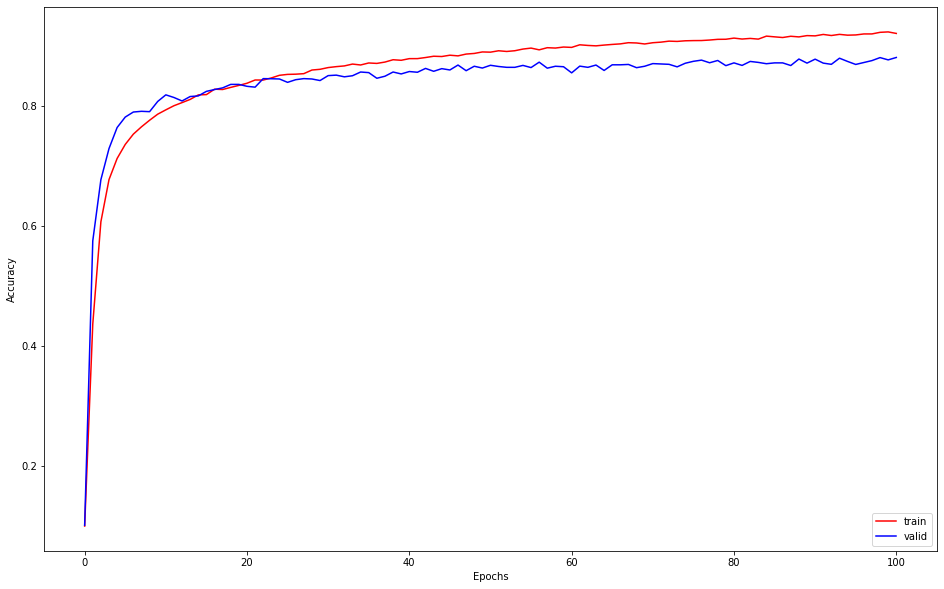

In [53]:
plt.figure(figsize=(16, 10))
plt.plot(range(101), model4_hist['metrics'], label='train', c='r')
plt.plot(range(101), model4_hist['val_metrics'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

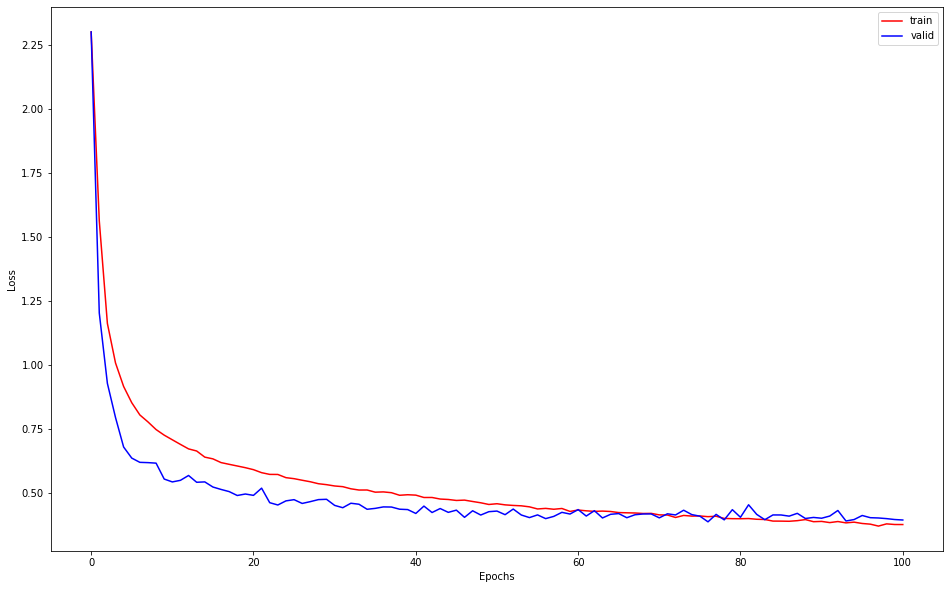

In [54]:
plt.figure(figsize=(16, 10))
plt.plot(range(101), model4_hist['loss'], label='train', c='r')
plt.plot(range(101), model4_hist['val_loss'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Судя по графику потерь, процесс обучения замедляется примерно на 30 эпохе. 

Попробуем еще больше ускорить/улучшить сходимость.

Для этого внесем изменения в функцию обучения модели. Каждые 30 эпох текущий learning rate оптимизатора будем делить на 3.

In [55]:
def training_model(model, criterion, optimizer, train_set, valid_set, epochs, device):
    history = {
        'loss': [], 
        'metrics': [], 
        'val_loss': [], 
        'val_metrics': []
    }
    
    # Определение количества знаков для красивого вывода    
    steps = len(train_set)
    steps_n_signs = len(str(steps))
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_metric = 0.0

        model.train()
        start_time = time.time()
        
        print(f'Epoch {epoch + 1}/{epochs}', end='\n')
        
        if (epoch + 1) % 30 == 0:
            optimizer.param_groups[0]['lr'] /= 3
        
        for i, data in enumerate(train_set):
            inputs, labels = data[0].to(device), data[1].to(device)
            # подсчет метрики на трейне осуществляется по полноценному предсказанию
            # т.е. без учета dropout и пр.
            preds = get_predicts(model, inputs)
            
            # Обнуляем градиент
            optimizer.zero_grad()

            # Делаем предсказание
            outputs = model(inputs)
            # Рассчитываем лосс-функцию
            loss = criterion(outputs, labels)
            # Делаем шаг назад по лоссу
            loss.backward()
            # Делаем шаг нашего оптимайзера
            optimizer.step()
            
#             preds = torch.max(outputs, dim=1).indices

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_metric += accuracy(preds, labels)
            
            epoch_loss = running_loss / (i + 1)
            epoch_metric = running_metric / (i + 1)

            print(
                '\r' \
                f'step [{str(i + 1).zfill(steps_n_signs)}/{steps}] - ' \
                f'loss: {epoch_loss:.4f} - ' \
                f'accuracy: {epoch_metric:.4f} ', 
                end='', flush=True)
        
        duration = round(time.time() - start_time)
        
        val_loss, val_metric = evaluate_model(model, valid_set, device, criterion)
        
        history['loss'].append(epoch_loss)
        history['metrics'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metrics'].append(val_metric)
        
        print(
            f'- val_loss: {val_loss:.4f} ' \
            f'- val_accuracy: {val_metric:.4f} ' \
            f'- {duration}s ({round((duration/steps) * 1000)}ms/step)', 
            end='\n')

    print('Training is finished!')
    
    return history

In [56]:
%%time
model5 = Net(10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters())

train_loss, train_acc = evaluate_model(model5, train_loader, device, criterion)
valid_loss, valid_acc = evaluate_model(model5, valid_loader, device, criterion)

model5_hist = training_model(model5, criterion, optimizer, train_loader, valid_loader, epochs=100, device=device)


model5_hist['loss'] = [train_loss] + model5_hist['loss']
model5_hist['metrics'] = [train_acc] + model5_hist['metrics']

model5_hist['val_loss'] = [valid_loss] + model5_hist['val_loss']
model5_hist['val_metrics'] = [valid_acc] + model5_hist['val_metrics']

models['BatchNorm + IC (augmented data) reduc_lr'] = model5

Epoch 1/100
step [782/782] - loss: 1.5148 - accuracy: 0.4518 - val_loss: 1.1100 - val_accuracy: 0.6026 - 16s (20ms/step)
Epoch 2/100
step [782/782] - loss: 1.1187 - accuracy: 0.6262 - val_loss: 0.9148 - val_accuracy: 0.6828 - 16s (20ms/step)
Epoch 3/100
step [782/782] - loss: 0.9788 - accuracy: 0.6835 - val_loss: 0.7276 - val_accuracy: 0.7516 - 16s (20ms/step)
Epoch 4/100
step [782/782] - loss: 0.8930 - accuracy: 0.7183 - val_loss: 0.6655 - val_accuracy: 0.7724 - 16s (20ms/step)
Epoch 5/100
step [782/782] - loss: 0.8372 - accuracy: 0.7419 - val_loss: 0.6768 - val_accuracy: 0.7726 - 17s (22ms/step)
Epoch 6/100
step [782/782] - loss: 0.8026 - accuracy: 0.7555 - val_loss: 0.6633 - val_accuracy: 0.7744 - 17s (22ms/step)
Epoch 7/100
step [782/782] - loss: 0.7628 - accuracy: 0.7714 - val_loss: 0.5939 - val_accuracy: 0.7980 - 17s (22ms/step)
Epoch 8/100
step [782/782] - loss: 0.7296 - accuracy: 0.7840 - val_loss: 0.5731 - val_accuracy: 0.8086 - 17s (22ms/step)
Epoch 9/100
step [782/782] - los

step [782/782] - loss: 0.3630 - accuracy: 0.9220 - val_loss: 0.3822 - val_accuracy: 0.8772 - 17s (22ms/step)
Epoch 69/100
step [782/782] - loss: 0.3606 - accuracy: 0.9234 - val_loss: 0.3864 - val_accuracy: 0.8766 - 17s (22ms/step)
Epoch 70/100
step [782/782] - loss: 0.3574 - accuracy: 0.9242 - val_loss: 0.3911 - val_accuracy: 0.8732 - 17s (22ms/step)
Epoch 71/100
step [782/782] - loss: 0.3553 - accuracy: 0.9238 - val_loss: 0.3814 - val_accuracy: 0.8746 - 17s (22ms/step)
Epoch 72/100
step [782/782] - loss: 0.3586 - accuracy: 0.9252 - val_loss: 0.3768 - val_accuracy: 0.8800 - 17s (22ms/step)
Epoch 73/100
step [782/782] - loss: 0.3528 - accuracy: 0.9241 - val_loss: 0.3800 - val_accuracy: 0.8796 - 17s (22ms/step)
Epoch 74/100
step [782/782] - loss: 0.3567 - accuracy: 0.9243 - val_loss: 0.3856 - val_accuracy: 0.8742 - 17s (22ms/step)
Epoch 75/100
step [782/782] - loss: 0.3562 - accuracy: 0.9244 - val_loss: 0.3726 - val_accuracy: 0.8812 - 17s (22ms/step)
Epoch 76/100
step [782/782] - loss: 0

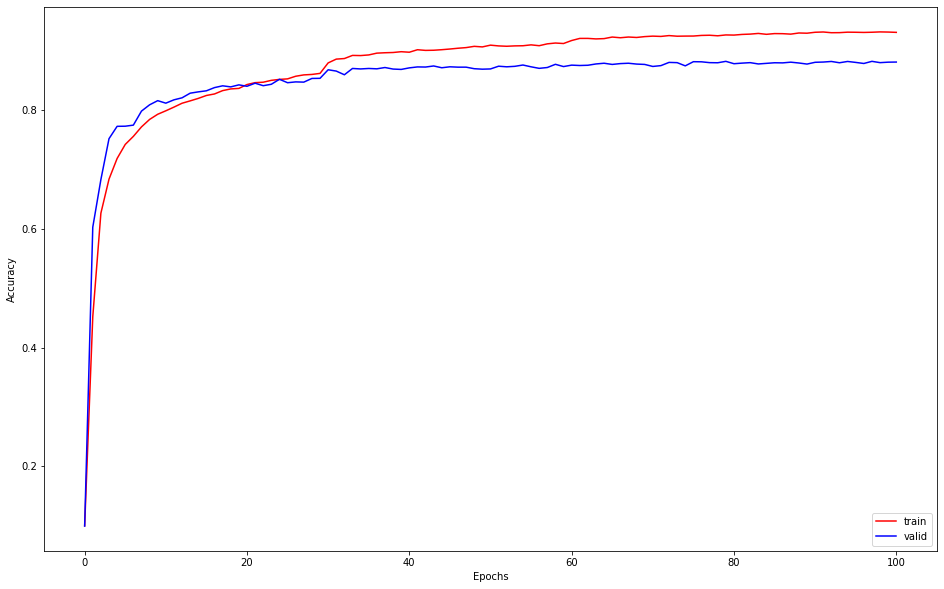

In [57]:
plt.figure(figsize=(16, 10))
plt.plot(range(101), model5_hist['metrics'], label='train', c='r')
plt.plot(range(101), model5_hist['val_metrics'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

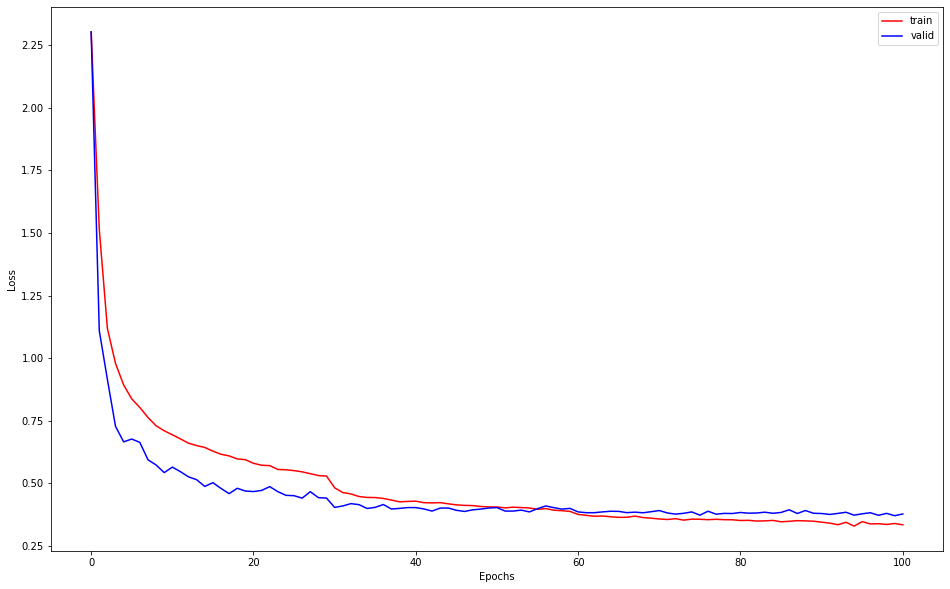

In [58]:
plt.figure(figsize=(16, 10))
plt.plot(range(101), model5_hist['loss'], label='train', c='r')
plt.plot(range(101), model5_hist['val_loss'], label='valid', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

**Проверим обученые модели на тестовой выборке.**

In [78]:
valid_metrics = [evaluate_model(model, valid_loader, device, criterion)[1] for model in models.values()]
test_metrics = [evaluate_model(model, test_loader, device, criterion)[1] for model in models.values()]

columns = ['model', 'valid', 'test']

pd.DataFrame(zip(models.keys(), valid_metrics, test_metrics), columns=columns)

,model,valid,test
0,from_lesson,0.6198,0.6140
1,baseline,0.7974,0.7872
2,IC,0.8526,0.8502
3,IC (augmented data),0.8568,0.8718
4,BatchNorm + IC (augmented data),0.8800,0.8828
5,BatchNorm + IC (augmented data) reduc_lr,0.8806,0.8842


**Выводы:**

Относительно несложная сеть может быть значительно улучшена без увеличения числа параметров. 

* Слои IC (BatchNorm + Dropout) позволили значительно ускорить и улучшить сходимость сети; 
* Cочетание аугментации данных и добавление дополнительного слоя BatchNorm позволило поднять метрику на отложенной выборке до 0.88;
* Изменение learning rate в процессе обучения позволило получить более быстрое схождение. 